In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition, manifold, preprocessing, model_selection

sns.set_theme()

### Parameters

In [2]:
test_size = 0.2
train_size = 1 - test_size
random_seed = 42

class_code_to_class_name = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)',
}

class_code_to_id = {}
id_to_class_code = {}
id_to_class_name = {}
for i, code in enumerate(class_code_to_class_name.keys()):
    class_code_to_id[code] = i
    id_to_class_code[i] = code
    id_to_class_name[i] = class_code_to_class_name[code]
    
num_classes = len(class_code_to_id)

In [3]:
def remap_labels(y):
    '''Converts class codes into consecutive ids.'''
    remap_y = y.copy()
    for class_code, class_id in class_code_to_id.items():
        remap_y[y == class_code] = class_id
    return remap_y

X = np.load('./features.npy')
y_orig = np.load('./labels.npy')
y = remap_labels(y_orig)

print(f'Number of classes: {num_classes}')
print(f'Number of features: {X.shape[1]}')
print(f'Number of samples: {X.shape[0]}')

Number of classes: 12
Number of features: 88
Number of samples: 25853


In [4]:
def plot_class_distribution(y, ax, title):
    labels, counts = np.unique(y, return_counts=True)
    counts = counts / counts.sum()
    
    ax.bar(labels, counts, align='center')
    ax.set_xticks(list(id_to_class_name.keys()), list(id_to_class_name.values()), rotation=45, ha='right')
    ax.set_title(title)

### Create test set

Number of train samples: 20682
Number of test samples: 5171


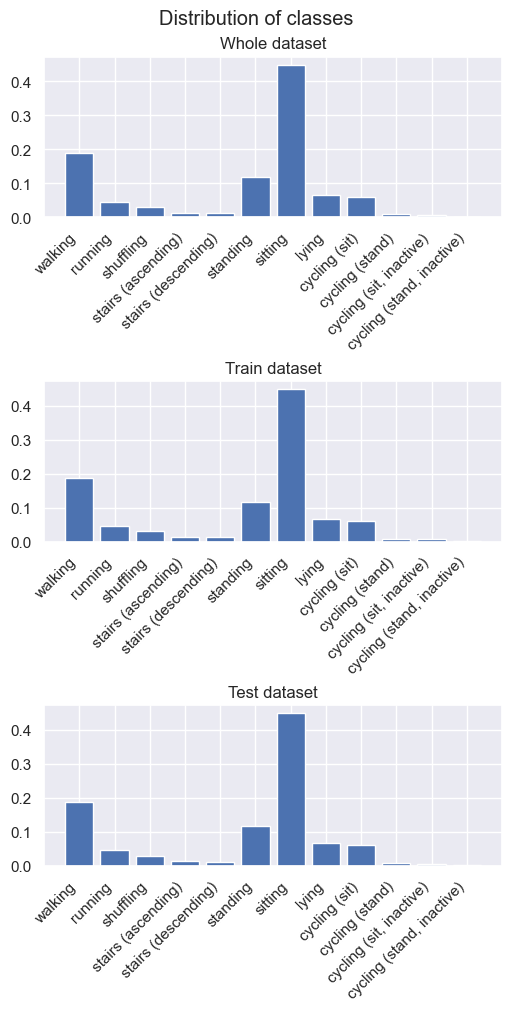

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    stratify=y,
                                                                    test_size=test_size,
                                                                    random_state=random_seed)
print(f'Number of train samples: {X_train.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

fig = plt.figure(figsize=(5, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 1)

ax = fig.add_subplot(gs[0, 0])
plot_class_distribution(y, ax, title='Whole dataset')

ax = fig.add_subplot(gs[1, 0])
plot_class_distribution(y, ax, title='Train dataset')

ax = fig.add_subplot(gs[2, 0])
plot_class_distribution(y, ax, title='Test dataset')

plt.suptitle('Distribution of classes')
plt.show()
plt.close()

### PCA

In [6]:
def plot_pca(X_pca, y, n_components):
    X_list = [X_pca[:, i] for i in range(n_components)]
    
    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()        
    ax.scatter(*X_list, c=y)
    ax.set_title(f'Distribution of data using PCA with {n_components = }')
    plt.show()
    plt.close()

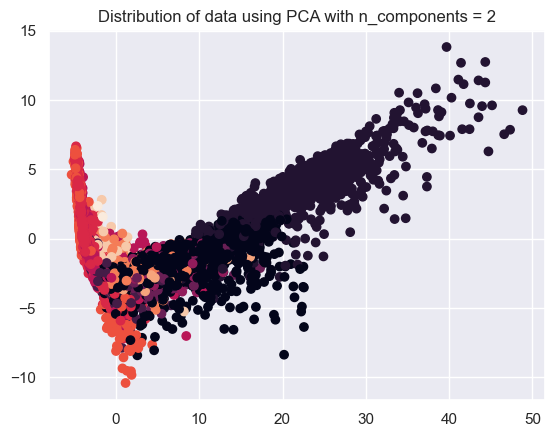

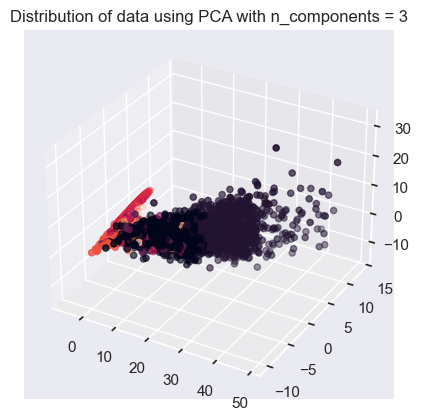

In [7]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

pca = decomposition.PCA()
pca.fit(X_train_norm)
X_train_norm_pca = pca.transform(X_train_norm)
X_test_norm_pca = pca.transform(X_test_norm)
        
plot_pca(X_train_norm_pca, y_train, n_components=2)
plot_pca(X_train_norm_pca, y_train, n_components=3)

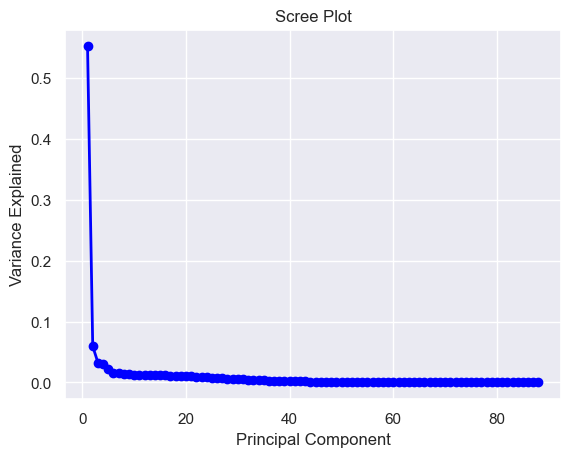

In [8]:
x_ticks = np.arange(pca.n_components_) + 1
plt.plot(x_ticks, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## TSNE

Running TSNE


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


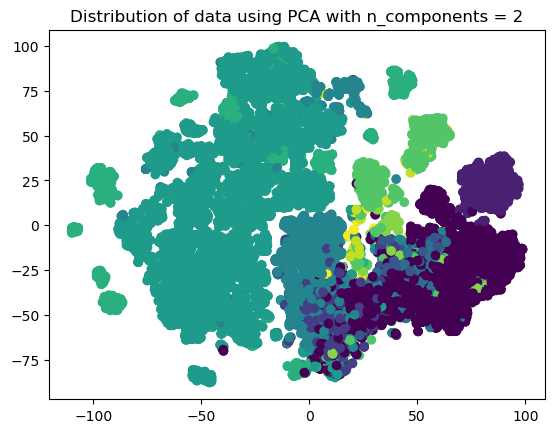

Running TSNE


/Users/akankshatyagi/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


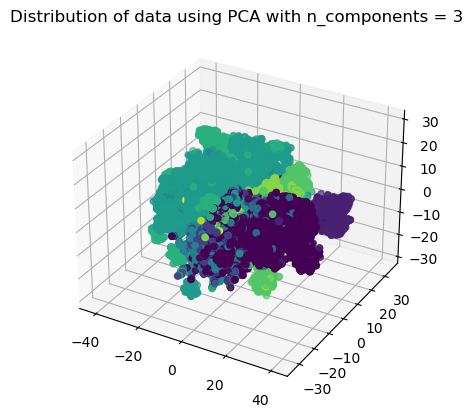

In [7]:
def plot_tsne(X, y, n_components):
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)

    print('Running TSNE')
    tsne = manifold.TSNE(
        n_components=n_components,
        init='pca',
        learning_rate='auto',
        n_jobs=4,
        random_state=0,
    )
    X_tsne = tsne.fit_transform(X)
    X_list = [X_tsne[:, i] for i in range(n_components)]
    
    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()        
    ax.scatter(*X_list, c=y)
    ax.set_title(f'Distribution of data using TSNE with {n_components = }')
    plt.show()
    plt.close()
    
plot_tsne(X_train, y_train, n_components=2)
plot_tsne(X_train, y_train, n_components=3)